In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = 'labeledSampledEksiComments.xlsx'
df = pd.read_excel(file_path)
df['Label'].value_counts()

Label
not insightful    3707
insightful        1293
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

label_mapping = {'not insightful': 0, 'insightful': 1}
df['FinalLabel'] = df['Label'].map(label_mapping)

df['FinalLabel'] = df['FinalLabel'].astype(int)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=99)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=99)

print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

Training set size: 3500
Validation set size: 750
Test set size: 750


In [ ]:
train_df['FinalLabel'].value_counts()

FinalLabel
0    2610
1     890
Name: count, dtype: int64

In [ ]:
import torch
from transformers import BertTokenizer

# loading the tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=256, return_tensors='pt')

# tokenizing the datasets
train_encodings = tokenize_function(train_df['Comment'].tolist())
val_encodings = tokenize_function(val_df['Comment'].tolist())
test_encodings = tokenize_function(test_df['Comment'].tolist())

class EksiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels = [int(label) for label in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        label = int(self.labels[idx])
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EksiDataset(train_encodings, train_df['FinalLabel'].tolist())
val_dataset = EksiDataset(val_encodings, val_df['FinalLabel'].tolist())
test_dataset = EksiDataset(test_encodings, test_df['FinalLabel'].tolist())

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, BertForSequenceClassification
from transformers import TrainingArguments

model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=2,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,                # Log every 10 steps
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True      # Load the best model at the end of training
)

def compute_metrics(eval_pred):
    precision_metric = load_metric("precision")
    recall_metric = load_metric("recall")
    f1_metric = load_metric("f1")
    accuracy_metric = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    labels = torch.tensor(labels)

    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1'],
        'accuracy': accuracy['accuracy']
    }

# initializing the Trainer
trainer = Trainer(
    model=model,                        # The model to train
    args=training_args,                 # Training arguments
    train_dataset=train_dataset,        # Training dataset
    eval_dataset=val_dataset,           # Evaluation dataset
    compute_metrics=compute_metrics     # Compute metrics function
)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.587600,0.324237,0.841387,0.845333,0.834760,0.845333
2,0.261200,0.338184,0.882625,0.876000,0.878225,0.876000


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


TrainOutput(global_step=876, training_loss=0.40125349126586085, metrics={'train_runtime': 19319.3612, 'train_samples_per_second': 0.362, 'train_steps_per_second': 0.045, 'total_flos': 920888693760000.0, 'train_loss': 0.40125349126586085, 'epoch': 2.0})

In [ ]:
# evaluating the model on the validation set
val_metrics = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation metrics: {val_metrics}")

Validation metrics: {'eval_loss': 0.3242371678352356, 'eval_precision': 0.8413865703101476, 'eval_recall': 0.8453333333333334, 'eval_f1': 0.8347596813234596, 'eval_accuracy': 0.8453333333333334, 'eval_runtime': 585.8533, 'eval_samples_per_second': 1.28, 'eval_steps_per_second': 0.16, 'epoch': 2.0}


In [ ]:
# evaluating the model on the test set
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test metrics: {test_metrics}")

Test metrics: {'eval_loss': 0.3530464768409729, 'eval_precision': 0.8112876526458616, 'eval_recall': 0.8186666666666667, 'eval_f1': 0.8053513937406431, 'eval_accuracy': 0.8186666666666667, 'eval_runtime': 586.65, 'eval_samples_per_second': 1.278, 'eval_steps_per_second': 0.16, 'epoch': 2.0}


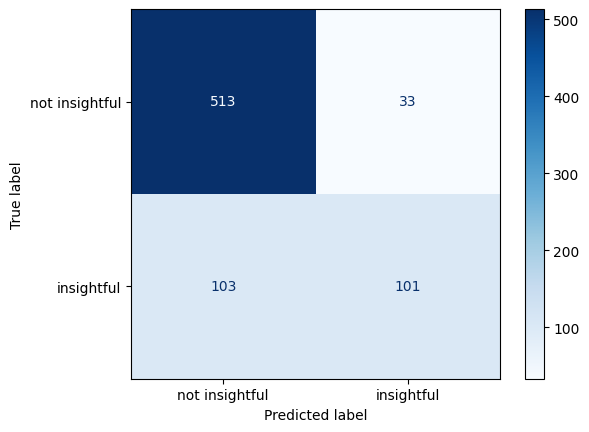

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions
labels = predictions_output.label_ids

predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not insightful', 'insightful'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# generating predictions for the test set
predictions_output = trainer.predict(test_dataset)
pred_labels = predictions_output.predictions.argmax(-1)
actual_labels = predictions_output.label_ids

label_mapping_reverse = {0: 'not insightful', 1: 'insightful'}
pred_labels_str = [label_mapping_reverse[label] for label in pred_labels]
actual_labels_str = [label_mapping_reverse[label] for label in actual_labels]

results_df = pd.DataFrame({
    'Comment': test_df['Comment'].tolist(),
    'Actual_Label': actual_labels_str,
    'Predicted_Label': pred_labels_str
})

results_csv_path = 'testEksiClassifiedBERT.csv'
results_df.to_csv(results_csv_path, index=False)

files.download(results_csv_path)